In [3]:
import numpy as np
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize
from scipy.optimize import root
from scipy.optimize import fsolve

## SN Curve Prediction - Reverse Engineering

### Data Generation from an SN Curve

In [4]:
def S_e(a,b, S_uts, S_100):
    S_a  = 0.5*(b - a)*S_100
    S_m  = 0.5*(b + a)*S_100
    S_e  = S_a/(1-S_m/S_uts)
    
    return S_e

In [5]:
s_100 = 210
S_100 = s_100**2 # Stress Parameter

### Reverse Engineering the process to estimate S_uts (Ultimate Tensile Strength)

In [17]:
a_ar = np.array([0.40, 0.70, 0.40, 0.33])**2
b_ar = np.array([1.00, 1.00, 0.80, 0.66])**2

N  = [131300, 915400, 8664200, 173210400 ]

In [18]:
print(b_ar)
print(a_ar)

[1.     1.     0.64   0.4356]
[0.16   0.49   0.16   0.1089]


In [36]:
S_uts_arr = np.array([])

for i in range(4):
    a_new = np.delete(a_ar,i)
    b_new = np.delete(b_ar,i)
    N_new = np.delete(N, i)
    
    Sa_new = 0.5*(b_new - a_new)*S_100
    Sm_new = 0.5*(b_new + a_new)*S_100
    
    c1 = np.around( np.log(N_new[1]/N_new[0])/np.log(N_new[2]/N_new[0]) , decimals = 4)

    c2 = np.around( (Sa_new[2]**c1)/(Sa_new[1]*Sa_new[0]**(c1-1)) , decimals = 4)

    c3 = np.around( (Sm_new[2]**c1)/(Sm_new[1]*Sm_new[0]**(c1-1)) , decimals = 4)

    r = root(lambda d: (d/Sm_new[2] -1)**c1 - (c2/c3)*(d/Sm_new[1] -1)*(d/Sm_new[0] -1)**(c1-1), S_100)
    
    #print(i,r.x[0])
    
    S_uts_arr = np.append(r.x[0],S_uts_arr)


S_uts_est = np.mean(S_uts_arr)
print(S_100, S_uts_est)

44100 80851.83992674817


### Reverse Engineering the process to estimate m (slope of sn curve)

In [26]:
m_est_ar = np.array([])

for i in range(4):
    
    Se1 = S_e(a_ar[i], b_ar[i], S_uts_est, S_100)
    N1 = N[i]
    
    for j in range(i+1,4,1):
        
            Se2 = S_e(a_ar[j], b_ar[j], S_uts_est, S_100)
            N2 = N[j]
            
            m_temp = (np.log(N2/N1))/(np.log(Se1/Se2))
            
            m_est_ar = np.append(m_est_ar, m_temp)
            
m_est = np.round( np.mean(m_est_ar),2)     

print(m_est)

6.2


### Reverse Engineering the process to estimate k in NS^m = k

In [27]:
k_est_arr = np.array([])

for i in range(4):
    Se = S_e(a_ar[i], b_ar[i], S_uts_est, S_100)
    k_temp = N[i]*(Se**m_est)
    
    k_est_arr = np.append(k_est_arr, k_temp)

k_est = np.mean(k_est_arr)

print(k_est)

3.6204973441240685e+32


### Verification of results

In [33]:
a_ver = np.array([0.40, 0.70, 0.40, 0.33, 0.3333, 0.5833])**2
b_ver = np.array([1.00, 1.00, 0.80, 0.66, 0.8333, 0.8333])**2

N_ver = np.array([131300, 915400, 8664200, 173210400, 2403300, 37737400])

In [34]:
N_pred = np.array([])
Se_ver_arr = np.array([])

for i in range(6):
    Se_ver = S_e(a_ver[i], b_ver[i], S_uts_est, S_100)
    Se_ver_arr = np.append(Se_ver_arr, Se_ver)
    Sem = Se_ver**m_est
    N_pred_temp = k_est/Sem
    N_pred = np.append(N_pred,N_pred_temp)

error = 100*(N_pred/N_ver-1)
print(N_ver)
print(N_pred)
print(error)

[   131300    915400   8664200 173210400   2403300  37737400]
[1.18863277e+05 1.09287095e+06 8.77429294e+06 1.61832539e+08
 2.58956945e+06 3.40429755e+07]
[-9.47199042 19.38725654  1.2706648  -6.56880925  7.75056985 -9.78982256]


### Plots 

In [31]:
print(np.log(N))

[11.78524006 13.72711641 15.97471015 18.9700176 ]


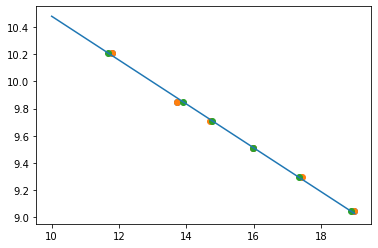

In [35]:
Se_arr = np.array([])

for i in range(4):
    Se_temp = S_e(a_ar[i], b_ar[i], S_uts_est, S_100)
    Se_arr = np.append(Se_arr, Se_temp)
    
logN_line = range(10,20,1)
logS_line = (np.log(k_est) - logN_line)/m_est

plt.scatter( np.log(N), np.log(Se_arr) )
plt.scatter( np.log(N_ver), np.log(Se_ver_arr) )
plt.scatter( np.log(N_pred), np.log(Se_ver_arr))
plt.plot(logN_line,logS_line)